In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
#pylab.rcParams['figure.figsize'] = (20,10)
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
#from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
#from fredapi import Fred
#fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
#import pandas_datareader.data as web
# from pandas_to_latex import pandas_to_latex, results_to_latex
from scipy.optimize import minimize
import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
import pypfopt

In [25]:
a = pypfopt.EfficientFrontier(rf.mean(),rf.cov().to_numpy())
list(a.min_volatility().values())

[0.0,
 0.0,
 0.0723079998632106,
 0.0,
 0.2329026772756198,
 0.0,
 0.1986476822006377,
 0.1072826038757764,
 0.0977585568356742,
 0.1833715789245206,
 0.1077289010245608]

In [21]:
tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2007,1,3))
end = tz.localize(dt.today())
%matplotlib inline

In [5]:
def get_weight_1(df):#df should be in the form of [ticker1,ticker2,........] as columns, and date as the row 
    mu = df.mean().to_numpy()
    cov = df.cov().to_numpy()
    cov_inv = np.linalg.inv(cov)
    weight = cov_inv @ np.ones(len(cov_inv))
    weight = weight / np.sum(weight)
    #print(np.sqrt(weight.T@cov@weight))


    return weight

In [6]:
def get_weight(cov):#df should be in the form of [ticker1,ticker2,........] as columns, and date as the row 
    #mu = df.mean().to_numpy()
    cov_inv = np.linalg.inv(cov)
    weight = cov_inv @ np.ones(len(cov_inv))
    weight = weight / np.sum(weight)
    return weight

def minimum_variance_portfolio(covariance):
    """
    Finds the weights of the minimum variance portfolio under the mean-variance framework.

    Parameters:
        covariance (ndarray): The covariance matrix of stock returns.

    Returns:
        ndarray: The weights of the minimum variance portfolio.
    """
    n = covariance.shape[0]
    initial_weights = np.ones(n) / n  # initialize with equal weights

    # Define the optimization objective function
    def objective_function(weights, covariance):
        return np.dot(weights, np.dot(covariance, weights))

    # Define the constraints for the optimization problem
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # sum of weights must be 1

    # Define the bounds for the optimization problem
    bounds = [(0, 1) for i in range(n)]  # weights must be between 0 and 1

    # Solve the optimization problem
    result = minimize(objective_function, initial_weights, args=(covariance,), method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

# data:

In [46]:
train_data=pd.read_csv('/Users/bill/Desktop/FinRL/Project/Data/csv/train_tech.csv')
trade_data=pd.read_csv('/Users/bill/Desktop/FinRL/Project/Data/csv/trade_tech.csv')


#train:
return_df = train_data[['permno','tic','date','moribvol','ret_1']]
rf = return_df.set_index(['date','tic'])['ret_1'].unstack().dropna()

#trade:
test = trade_data[['permno','tic','date','moribvol','ret_1']]
test = test.set_index(['date','tic'])['ret_1'].unstack()
test = test.dropna()

rf.index = pd.to_datetime(rf.index)
test.index = pd.to_datetime(test.index)

## Buy and hold Mean-var

In [47]:
return_matrix

array([[ 0.02109778,  0.05191263,  0.00797729, ...,  0.01134978,
         0.02709104, -0.00052412],
       [ 0.02459318,  0.04935062,  0.00280836, ...,  0.00136482,
        -0.00129115,  0.01992664],
       [-0.01097531, -0.01980196,  0.01384963, ...,  0.00666367,
         0.00766462,  0.05912594],
       ...,
       [-0.00304355, -0.02097667, -0.00531582, ..., -0.01863588,
        -0.00733711,  0.00895354],
       [-0.00184583, -0.00861178, -0.00392958, ...,  0.00076615,
        -0.00496279, -0.01053802],
       [ 0.00899747,  0.04405846, -0.00331386, ...,  0.01826441,
         0.01130156,  0.03867716]])

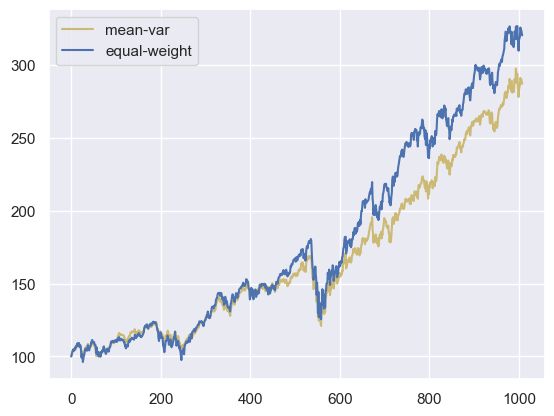

In [48]:
#Given initial capital 100, see how the portfolio goes from Jan 2018 to Dec.2021:
a = pypfopt.EfficientFrontier(rf.mean(),rf.cov().to_numpy())
weight = list(a.min_volatility().values())
initial_wealth = 100
return_matrix = test.to_numpy()
cummulative_value_mean_var = [100]
cummulative_value_eq_weight = [100]
#cummulative_value_market_cap=[100]

for i in range(len(return_matrix)-1):
    total_return_rate = weight @ return_matrix[i]
    total_return_rate_eq = ( np.ones(len(return_matrix[i])) / len(return_matrix[i])) @ return_matrix[i]
    
    cummulative_value_mean_var.append(cummulative_value_mean_var[i]*(1+total_return_rate))
    cummulative_value_eq_weight.append(cummulative_value_eq_weight[i]*(1+total_return_rate_eq))

fig,ax = plt.subplots()

dates = test.index

#plt.plot_date(dates,cummulative_value_mean_var,'y',label = 'mean-var')
#plt.plot_date(dates,cummulative_value_eq_weight,'b',label = 'equal-weight',)

plt.plot(cummulative_value_mean_var,'y',label = 'mean-var')
plt.plot(cummulative_value_eq_weight,'b',label = 'equal-weight',)
plt.legend()    

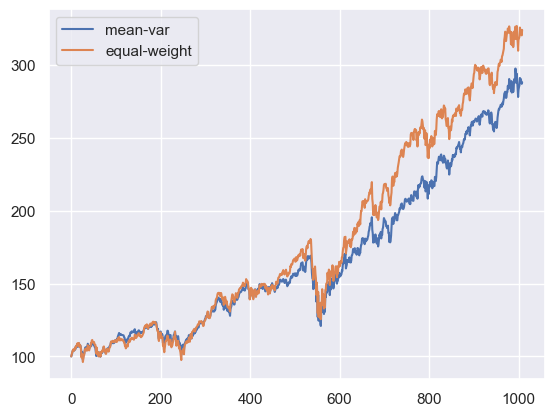

In [49]:
initial_wealth = 100
return_matrix = test.to_numpy()
cummulative_value_mean_var = [100]
cummulative_value_eq_weight = [100]

#cummulative_value_market_cap=[100]

for i in range(len(return_matrix)):
    total_return_rate = weight @ return_matrix[i]
    total_return_rate_eq = ( np.ones(len(return_matrix[i])) / len(return_matrix[i])) @ return_matrix[i]
    
    cummulative_value_mean_var.append(cummulative_value_mean_var[i]*(1+total_return_rate))
    #print(cummulative_value_mean_var[i])
    cummulative_value_eq_weight.append(cummulative_value_eq_weight[i]*(1+total_return_rate_eq))

fig,ax = plt.subplots()

plt.plot(cummulative_value_mean_var,label = 'mean-var')
plt.plot(cummulative_value_eq_weight,label = 'equal-weight')
plt.legend()    

# Adding Rolling Window

In [50]:
return_matrix = rf.to_numpy()
return_matrix

array([[ 0.01898423,  0.01383199,  0.02632526, ...,  0.04511486,
         0.0189076 ,  0.00880673],
       [ 0.01451726, -0.00404254,  0.00035138, ..., -0.01174975,
        -0.01168385, -0.02531645],
       [-0.00310043, -0.01217655,  0.00561995, ..., -0.01111399,
         0.00486785, -0.01656967],
       ...,
       [ 0.00468539,  0.00189938,  0.00077798, ..., -0.00247914,
         0.00277433,  0.01436173],
       [-0.00228417, -0.02559246, -0.00751492, ..., -0.00559181,
        -0.00362524, -0.00314628],
       [ 0.0218449 ,  0.06809337,  0.01462145, ...,  0.01843175,
         0.01081958,  0.00368226]])

In [51]:
n_assets = return_matrix.shape[1]

cov = rf.rolling('120D').cov().iloc[n_assets:,:]
cov

tic                  ADSK       AMD      CSCO      FSLR      INTU      LRCX  \
date       tic                                                                
2007-01-04 ADSK  0.000010  0.000040  0.000058  0.000066  0.000036  0.000114   
           AMD   0.000040  0.000160  0.000232  0.000265  0.000145  0.000457   
           CSCO  0.000058  0.000232  0.000337  0.000385  0.000211  0.000663   
           FSLR  0.000066  0.000265  0.000385  0.000439  0.000241  0.000757   
           INTU  0.000036  0.000145  0.000211  0.000241  0.000132  0.000415   
...                   ...       ...       ...       ...       ...       ...   
2017-12-29 MSFT  0.000066  0.000054  0.000015  0.000248  0.000032  0.000081   
           ORCL  0.000025  0.000003  0.000009  0.000024  0.000007  0.000038   
           QCOM  0.000075  0.000138  0.000042  0.000269  0.000035  0.000082   
           TXN   0.000070  0.000116  0.000036  0.000106  0.000022  0.000114   
           WU    0.000020  0.000016  0.000020 -0.000022  0.000009  0.000047   

tic                  MSFT          ORCL      QCOM       TXN            WU  
date       tic                                                             
2007-01-04 ADSK  0.000009  2.673758e-05  0.000127  0.000068  7.621360e-05  
           AMD   0.000036  1.069901e-04  0.000508  0.000273  3.049679e-04  
           CSCO  0.000052  1.554698e-04  0.000738  0.000397  4.431558e-04  
           FSLR  0.000060  1.774228e-04  0.000843  0.000453  5.057313e-04  
           INTU  0.000033  9.723122e-05  0.000462  0.000248  2.771508e-04  
...                   ...           ...       ...       ...           ...  
2017-12-29 MSFT  0.000120  2.663519e-05  0.000039  0.000038  1.408436e-05  
           ORCL  0.000027  1.540375e-04 -0.000005  0.000002 -8.378182e-08  
           QCOM  0.000039 -5.307517e-06  0.000411  0.000051 -4.729085e-05  
           TXN   0.000038  2.035004e-06  0.000051  0.000073  1.851765e-05  
           WU    0.000014 -8.378182e-08 -0.000047  0.000019  9.844838e-05  

[30448 rows x 11 columns]

In [52]:
cov = rf.rolling('120D').cov()

def get_cov_matrix(date):
    return cov.loc[date].to_numpy()

def get_mean_return(date):
    return rf.rolling('120D').mean().loc[date].to_numpy()

## Mean-Variance Daily Action and plot

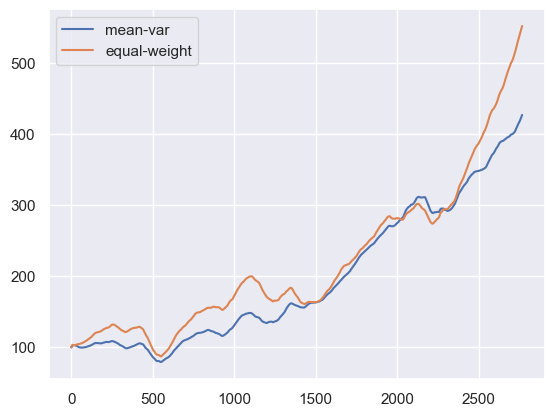

In [53]:
#start from 121th date as we have a rolling window of 120 Days
start = 1
current_date = rf.index[start]
#trade actions
action = []
weight = []
a = np.zeros(11)


cummulative_value_mean_var = [100]

cummulative_value_eq_weight = [100]

for i in range(len(return_matrix)-2):
    #print(current_date)
    #current_weight =get_weight(get_cov_matrix(current_date))
    ef = pypfopt.EfficientFrontier(np.ones(11),get_cov_matrix(current_date))
    current_weight = list(ef.min_volatility().values())
    weight.append(current_weight)
    #print(sum(current_weight))
    action.append(np.array(current_weight) -  np.array(a))
    a = current_weight
    #a = get_weight(get_cov_matrix(current_date))
    # a is just the newest weight    
    
    return_vector = get_mean_return(current_date)
    #print(return_vector)
    total_return_rate_eq = ( np.ones(len(return_vector)) / len(return_vector) ) @ return_vector
    total_return_rate = a @ return_vector
    
    cummulative_value_mean_var.append(cummulative_value_mean_var[i]*(1+total_return_rate))
    cummulative_value_eq_weight.append(cummulative_value_eq_weight[i]*(1+total_return_rate_eq))


    
    current_date = rf.index[start+i+1]

fig,ax = plt.subplots()
plt.plot(cummulative_value_mean_var,label = 'mean-var')
plt.plot(cummulative_value_eq_weight,label = 'equal-weight')
plt.legend()

In [57]:
weight_df = pd.DataFrame(weight)
weight_df.columns=rf.columns
weight_df.index=rf.index[1:-1]
weight_df
weight_df.to_csv('/Users/bill/Desktop/FinRL/Project/Data/csv/mean_var_weight.csv')


In [56]:
action_df = pd.DataFrame(action)
action_df.columns=rf.columns
action_df.index=rf.index[1:-1]

#Here's the action of trading in terms of weight of total capital

action_df.to_csv('/Users/bill/Desktop/FinRL/Project/Data/csv/action.csv')
action_df

tic,ADSK,AMD,CSCO,FSLR,INTU,LRCX,MSFT,ORCL,QCOM,TXN,WU
date,,,,,,,,,,,
2007-01-04,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
2007-01-05,0.403051,0.000000,0.000000,0.000000e+00,0.000000,0.0,-0.403051,0.000000,0.000000,0.000000,0.000000
2007-01-08,-0.002228,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.002228,0.000000,0.000000,0.000000,0.000000
2007-01-09,-0.106596,0.155308,0.000000,0.000000e+00,0.000000,0.0,-0.048713,0.000000,0.000000,0.000000,0.000000
2007-01-10,-0.034226,-0.009753,0.000000,1.000000e-16,0.000000,0.0,-0.380809,0.424788,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,0.000000,0.000000,0.001528,0.000000e+00,-0.000630,0.0,0.000028,0.001491,0.000110,0.000589,-0.003116
2017-12-22,0.000000,0.000000,0.001186,0.000000e+00,0.009011,0.0,-0.000974,0.000932,-0.002606,-0.002459,-0.005088
2017-12-26,0.000000,0.000000,0.000269,0.000000e+00,-0.000732,0.0,0.000768,0.000192,0.000034,0.000202,-0.000732


In [31]:
"""
window_size = 30
cols = list(rf.columns)
# calculate the rolling covariance between each pair of columns
rolling_cov = pd.DataFrame(index=rf.index, columns=cols)

for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        if j >= i and i ==1:
            print(rf[col1].rolling(window_size).cov(rf[col2]))


# view the resulting DataFrame
#print(rolling_cov)
"""

'\nwindow_size = 30\ncols = list(rf.columns)\n# calculate the rolling covariance between each pair of columns\nrolling_cov = pd.DataFrame(index=rf.index, columns=cols)\n\nfor i, col1 in enumerate(cols):\n    for j, col2 in enumerate(cols):\n        if j >= i and i ==1:\n            print(rf[col1].rolling(window_size).cov(rf[col2]))\n\n\n# view the resulting DataFrame\n#print(rolling_cov)\n'